In [130]:
import pandas as pd
import re
import string
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words()
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#read in data
df = pd.read_csv('realdonaldtrump.csv')

In [4]:
#convert date to datetime object
df['date']= pd.to_datetime(df['date'])

In [5]:
#check for nulls in columns of interest
df.isna().sum()


id               0
link             0
content          0
date             0
retweets         0
favorites        0
mentions     22966
hashtags     37769
dtype: int64

In [6]:
#since mentions, hashtags, and links dont have much for us to analyze, lets drop
df=df.drop(['link','mentions','hashtags'], axis=1)


In [7]:
df.head()

,id,content,date,retweets,favorites
0,1698308935,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917
1,1701461182,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26
4,1773561338,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945


In [8]:
#im really only interested in trump tweets after he became a political figure, 
#so I'm dropping tweets from before he anncounced his canidacy
mask = (df['date'] > '2015-06-16')
df = df.loc[mask]
df

,id,content,date,retweets,favorites
23278,610704372415229952,""" @ realJoeMurray: Hopefully tomorrow is the d...",2015-06-16 02:04:03,40,68
23279,610704441872883712,"""@brentcfritz: Today is the day America become...",2015-06-16 02:04:19,55,99
23280,610710557285556224,""" @ insuraider: @ realDonaldTrump is going to ...",2015-06-16 02:28:37,32,59
23281,610710626269306880,""" @ DONJUBBER: @ realDonaldTrump Shock the wor...",2015-06-16 02:28:54,17,33
23282,610710697140441088,""" @ PianoBecca: @ realDonaldTrump No Amercian,...",2015-06-16 02:29:11,23,33
...,...,...,...,...,...
43347,1273405198698975232,Joe Biden was a TOTAL FAILURE in Government. H...,2020-06-17 19:00:32,23402,116377
43348,1273408026968457216,Will be interviewed on @ seanhannity tonight a...,2020-06-17 19:11:47,11810,56659
43349,1273442195161387008,pic.twitter.com/3lm1spbU8X,2020-06-17 21:27:33,4959,19344
43350,1273442469066276864,pic.twitter.com/vpCE5MadUz,2020-06-17 21:28:38,4627,17022


In [9]:
df.reset_index()

,index,id,content,date,retweets,favorites
0,23278,610704372415229952,""" @ realJoeMurray: Hopefully tomorrow is the d...",2015-06-16 02:04:03,40,68
1,23279,610704441872883712,"""@brentcfritz: Today is the day America become...",2015-06-16 02:04:19,55,99
2,23280,610710557285556224,""" @ insuraider: @ realDonaldTrump is going to ...",2015-06-16 02:28:37,32,59
3,23281,610710626269306880,""" @ DONJUBBER: @ realDonaldTrump Shock the wor...",2015-06-16 02:28:54,17,33
4,23282,610710697140441088,""" @ PianoBecca: @ realDonaldTrump No Amercian,...",2015-06-16 02:29:11,23,33
...,...,...,...,...,...,...
20069,43347,1273405198698975232,Joe Biden was a TOTAL FAILURE in Government. H...,2020-06-17 19:00:32,23402,116377
20070,43348,1273408026968457216,Will be interviewed on @ seanhannity tonight a...,2020-06-17 19:11:47,11810,56659
20071,43349,1273442195161387008,pic.twitter.com/3lm1spbU8X,2020-06-17 21:27:33,4959,19344
20072,43350,1273442469066276864,pic.twitter.com/vpCE5MadUz,2020-06-17 21:28:38,4627,17022


## Cleaning ##

In [10]:
def clean(text):
    #make lowercase, remove links, characters, punctuation, etc.
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
    
    # removing the stop-words          
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stop_words]
    filtered_sentence = (" ").join(tokens_without_sw)
    text = filtered_sentence
    
    return text

In [11]:
# ls = LancasterStemmer()
# lem = WordNetLemmatizer()
# def lexicon_normalization(text):
#     words = word_tokenize(text)
#     words_stem = [ls.stem(w) for w in words]
#     words_lem = [lem.lemmatize(w) for w in words_stem]
    
#     return words_lem

In [12]:
df['clean'] = df['content'].apply(clean)
df

,id,content,date,retweets,favorites,clean
23278,610704372415229952,""" @ realJoeMurray: Hopefully tomorrow is the d...",2015-06-16 02:04:03,40,68,realjoemurray hopefully tomorrow day start mak...
23279,610704441872883712,"""@brentcfritz: Today is the day America become...",2015-06-16 02:04:19,55,99,brentcfritz today day america becomes great re...
23280,610710557285556224,""" @ insuraider: @ realDonaldTrump is going to ...",2015-06-16 02:28:37,32,59,insuraider realdonaldtrump going make hillarys...
23281,610710626269306880,""" @ DONJUBBER: @ realDonaldTrump Shock the wor...",2015-06-16 02:28:54,17,33,donjubber realdonaldtrump shock world trump4pr...
23282,610710697140441088,""" @ PianoBecca: @ realDonaldTrump No Amercian,...",2015-06-16 02:29:11,23,33,pianobecca realdonaldtrump amercian really imp...
...,...,...,...,...,...,...
43347,1273405198698975232,Joe Biden was a TOTAL FAILURE in Government. H...,2020-06-17 19:00:32,23402,116377,joe biden total failure government bungled eve...
43348,1273408026968457216,Will be interviewed on @ seanhannity tonight a...,2020-06-17 19:11:47,11810,56659,interviewed seanhannity tonight 900 pm enjoy
43349,1273442195161387008,pic.twitter.com/3lm1spbU8X,2020-06-17 21:27:33,4959,19344,pictwittercom3lm1spbu8x
43350,1273442469066276864,pic.twitter.com/vpCE5MadUz,2020-06-17 21:28:38,4627,17022,pictwittercomvpce5maduz


## Tokenize ##

In [13]:
df['tokens'] =datedf['clean'].apply(word_tokenize)

In [14]:
df

,id,content,date,retweets,favorites,clean,tokens
23278,610704372415229952,""" @ realJoeMurray: Hopefully tomorrow is the d...",2015-06-16 02:04:03,40,68,realjoemurray hopefully tomorrow day start mak...,"[realjoemurray, hopefully, tomorrow, day, star..."
23279,610704441872883712,"""@brentcfritz: Today is the day America become...",2015-06-16 02:04:19,55,99,brentcfritz today day america becomes great re...,"[brentcfritz, today, day, america, becomes, gr..."
23280,610710557285556224,""" @ insuraider: @ realDonaldTrump is going to ...",2015-06-16 02:28:37,32,59,insuraider realdonaldtrump going make hillarys...,"[insuraider, realdonaldtrump, going, make, hil..."
23281,610710626269306880,""" @ DONJUBBER: @ realDonaldTrump Shock the wor...",2015-06-16 02:28:54,17,33,donjubber realdonaldtrump shock world trump4pr...,"[donjubber, realdonaldtrump, shock, world, tru..."
23282,610710697140441088,""" @ PianoBecca: @ realDonaldTrump No Amercian,...",2015-06-16 02:29:11,23,33,pianobecca realdonaldtrump amercian really imp...,"[pianobecca, realdonaldtrump, amercian, really..."
...,...,...,...,...,...,...,...
43347,1273405198698975232,Joe Biden was a TOTAL FAILURE in Government. H...,2020-06-17 19:00:32,23402,116377,joe biden total failure government bungled eve...,"[joe, biden, total, failure, government, bungl..."
43348,1273408026968457216,Will be interviewed on @ seanhannity tonight a...,2020-06-17 19:11:47,11810,56659,interviewed seanhannity tonight 900 pm enjoy,"[interviewed, seanhannity, tonight, 900, pm, e..."
43349,1273442195161387008,pic.twitter.com/3lm1spbU8X,2020-06-17 21:27:33,4959,19344,pictwittercom3lm1spbu8x,[pictwittercom3lm1spbu8x]
43350,1273442469066276864,pic.twitter.com/vpCE5MadUz,2020-06-17 21:28:38,4627,17022,pictwittercomvpce5maduz,[pictwittercomvpce5maduz]


## EDA ##

In [15]:
p = Counter(" ".join(df['clean']).split()).most_common(10)
# rslt = pd.DataFrame(p, columns=['Word', 'Frequency'])
print(rslt)

NameError: name 'rslt' is not defined

## vectorize ##

In [24]:
count_vectorizer = CountVectorizer(stop_words = 'english')
words_count_vectorize = count_vectorizer.fit_transform(df.clean)
words_count_vectorize

<20074x23924 sparse matrix of type '<class 'numpy.int64'>'
	with 229113 stored elements in Compressed Sparse Row format>

In [25]:
df_words_count_vec = pd.DataFrame(data=words_count_vectorize)
features = count_vectorizer.get_feature_names()
df_words_count_vec = pd.DataFrame(words_count_vectorize.toarray(), columns=features)
df_words_count_vec

,00,007cigarjoe,007llisav,00patriot,03,05,08,09,0nonsense,10,...,वसन,सक,सच,सद,सन,सपन,सबस,सम,हम,हर
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20069,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Try TF-IDF ##

In [30]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
words_tfidf = tfidf_vectorizer.fit_transform(df.clean)
words_tfidf

<20074x23924 sparse matrix of type '<class 'numpy.float64'>'
	with 229113 stored elements in Compressed Sparse Row format>

In [31]:
features = tfidf_vectorizer.get_feature_names()
df_words_tfidf = pd.DataFrame(words_tfidf.toarray(), columns=features)
df_words_tfidf

,00,007cigarjoe,007llisav,00patriot,03,05,08,09,0nonsense,10,...,वसन,सक,सच,सद,सन,सपन,सबस,सम,हम,हर
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## topic modeling with NMF on countvectorizer ##

In [46]:
nmf = NMF(n_components=10, random_state=42)

# fit the transfomed content with NMF
nmf.fit(words_count_vectorize)

# display the result
for index,topic in enumerate(nmf.components_):
    print(f"The top 20 words for topic # {index}")
    print([count_vectorizer.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


The top 20 words for topic # 0
['time', 'really', 'tonight', 'senator', 'wonderful', 'fantastic', 'military', 'book', 'country', 'governor', 'night', 'congratulations', 'day', 'today', 'honor', 'state', 'job', 'make', 'america', 'great']


The top 20 words for topic # 1
['second', 'loves', 'need', 'immigration', 'democrats', 'southern', 'borders', 'amendment', 'complete', 'vets', 'vote', 'total', 'endorsement', 'security', 'country', 'crime', 'military', 'strong', 'wall', 'border']


The top 20 words for topic # 2
['bush', 'election', 'lead', 'hes', 'carson', 'vote', 'true', 'rubio', 'cruz', 'administration', 'tower', 'cnn', '2016', 'gop', 'foxnews', 'campaign', 'mr', 'poll', 'donald', 'trump']


The top 20 words for topic # 3
['white', 'house', 'totally', 'dont', 'sources', 'stories', 'russia', 'dishonest', 'reporting', 'ratings', 'said', 'like', 'good', 'bad', 'corrupt', 'story', 'cnn', 'media', 'fake', 'news']


The top 20 words for topic # 4
['rating', 'approval', 'american', 'hono

## topic modeling with NMF on tfidf ##

In [32]:
nmf = NMF(n_components=10, random_state=42)

# fit the transfomed content with NMF
nmf.fit(words_tfidf)

# display the result
for index,topic in enumerate(nmf.components_):
    print(f"The top 20 words for topic # {index}")
    print([count_vectorizer.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


The top 20 words for topic # 0
['jobs', 'business', 'votetrump', 'order', 'united', 'imwithyou', 'realdonaldtrump', 'deal', 'americafirst', 'vote', 'need', 'needs', 'crippled', 'making', 'going', 'lets', 'safe', 'great', 'make', 'america']


The top 20 words for topic # 1
['carolina', 'iowa', '95', 'pennsylvania', 'mike', 'poll', 'trump2016', 'ohio', 'party', 'working', 'florida', 'words', 'republican', 'approval', 'rating', 'honor', 'support', 'love', 'nice', 'thank']


The top 20 words for topic # 2
['republicans', 'vote', 'china', 'years', 'republican', 'american', 'military', 'strong', 'security', 'dont', 'crime', 'united', 'states', 'time', 'president', 'wall', 'country', 'democrats', 'border', 'people']


The top 20 words for topic # 3
['interview', 'best', 'need', 'megynkelly', 'poll', 'like', 'debate', 'love', 'gop', '2016', 'foxnews', 'vote', 'true', 'cnn', 'thanks', 'mr', 'president', 'donald', 'realdonaldtrump', 'trump']


The top 20 words for topic # 4
['sources', 'conferen

## Topic Modeling w LDA on count vectorizer ##

In [34]:
LDA = LatentDirichletAllocation(n_components = 10, n_jobs = -2, random_state = 42)

# fit the transfomed content with LDA
LDA.fit(words_count_vectorize)

# display the result
for index,topic in enumerate(LDA.components_):
    print(f"The top 20 words for topic # {index}")
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

The top 20 words for topic # 0
['japan', 'replace', 'soon', 'whitehouse', 'rating', 'healthcare', 'approval', 'thank', 'looking', 'prime', 'meeting', 'american', 'minister', 'obamacare', 'party', 'look', 'today', 'republican', 'great', 'forward']


The top 20 words for topic # 1
['like', 'wow', 'american', 'time', 'ted', 'going', 'president', 'good', 'people', 'way', 'cruz', 'pelosi', 'nancy', 'white', 'trump2016', 'new', 'trump', 'realdonaldtrump', 'house', 'thank']


The top 20 words for topic # 2
['work', 'obama', 'good', 'illegal', 'united', 'iran', 'like', 'bad', 'states', 'dont', 'immigration', 'president', 'great', 'security', 'hillary', 'wall', 'country', 'democrats', 'border', 'people']


The top 20 words for topic # 3
['report', 'time', 'bad', 'story', 'fbi', 'crooked', 'clinton', 'russia', 'collusion', 'said', 'hunt', 'witch', 'people', 'hillary', 'democrats', 'president', 'trump', 'media', 'fake', 'news']


The top 20 words for topic # 4
['rubio', 'live', 'night', 'pm', 'in

## Topic Moldeling w LDA on TFIDF  ##

In [35]:
LDA = LatentDirichletAllocation(n_components = 10, n_jobs = -2, random_state = 42)

# fit the transfomed content with LDA
LDA.fit(words_tfidf)

# display the result
for index,topic in enumerate(LDA.components_):
    print(f"The top 20 words for topic # {index}")
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

The top 20 words for topic # 0
['vpdebate', 'bruce', 'ohr', 'donald', 'jimmyfallon', 'makeamericagreatagain', 'disgraceful', 'look', 'india', 'american', 'today', 'abe', 'trump', 'forward', 'japan', 'great', 'realdonaldtrump', 'minister', 'prime', 'thank']


The top 20 words for topic # 1
['foxnews', 'people', 'pm', 'love', 'mark', 'today', 'white', 'house', 'read', 'oil', 'conference', 'new', 'wow', 'book', 'trump', 'great', 'realdonaldtrump', 'makeamericagreatagain', 'trump2016', 'thank']


The top 20 words for topic # 2
['united', 'republican', 'immigration', 'good', 'vote', 'time', 'dont', 'job', 'strong', 'crime', 'military', 'president', 'security', 'big', 'wall', 'democrats', 'country', 'people', 'border', 'great']


The top 20 words for topic # 3
['bad', 'campaign', 'said', 'mueller', 'story', 'clinton', 'fbi', 'russia', 'crooked', 'people', 'collusion', 'democrats', 'trump', 'president', 'hillary', 'witch', 'hunt', 'media', 'news', 'fake']


The top 20 words for topic # 4
['en

## NMF wth count vectorizer seems to give more interesting AND intuitive results ##

In [36]:
topic_words = pd.DataFrame(nmf.components_.round(10),
             index = ["component_1","component_2",
                     "component_3","component_4",
                     "component_5","component_6",
                     "component_7","component_8",
                    "component_9","component_10"],
             columns = tfidf_vectorizer.get_feature_names())
topic_words

,00,007cigarjoe,007llisav,00patriot,03,05,08,09,0nonsense,10,...,वसन,सक,सच,सद,सन,सपन,सबस,सम,हम,हर
component_1,0.000000,0.000000,0.004421,0.000000,0.000000,0.000798,0.000000,0.000000,0.000000,0.001328,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_2,0.000000,0.000000,0.000000,0.001223,0.000000,0.000000,0.000000,0.000000,0.000000,0.000891,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000425,0.000000,0.000000,0.000000,0.022080,...,7.500000e-09,7.500000e-09,9.506000e-07,7.500000e-09,9.506000e-07,3.400000e-09,4.700000e-09,9.161000e-07,9.062000e-07,9.506000e-07
component_4,0.001278,0.001220,0.011393,0.001538,0.000000,0.000000,0.000000,0.000000,0.001761,0.019162,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_5,0.000291,0.000000,0.000494,0.000000,0.000844,0.000000,0.000000,0.003162,0.000000,0.009473,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_7,0.000000,0.017183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_8,0.000077,0.000000,0.000000,0.000000,0.000072,0.000000,0.000069,0.002675,0.000000,0.050754,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003038,0.000000,0.000000,0.001890,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
component_10,0.000000,0.000000,0.000000,0.000000,0.003760,0.000011,0.000032,0.001961,0.000014,0.014913,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [43]:
model = nmf.fit(words_count_vectorize)
doc_topics = model.transform(words_count_vectorize)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [56]:
#greate topic makeup df
component_df = pd.DataFrame(doc_topics.round(10),
             index = [i for i in df.index],
             columns = ["component_1","component_2",
                     "component_3","component_4",
                     "component_5","component_6",
                     "component_7","component_8",
                    "component_9","component_10"])

component_df

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
23278,0.119420,0.000000,0.000000,0.000000,0.005877,0.000000,0.000721,0.185750,0.016622,0.00000
23279,0.106854,0.000000,0.000000,0.105906,0.000000,0.000000,0.003980,0.157989,0.005187,0.00000
23280,0.011351,0.000000,0.000000,0.001292,0.011741,0.000909,0.000000,0.179243,0.016186,0.01896
23281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003454,0.144971,0.000805,0.00000
23282,0.189296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157084,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...
43347,0.000000,0.022537,0.000321,0.002355,0.000000,0.002853,0.003870,0.000000,0.000108,0.00668
43348,0.002553,0.000000,0.000356,0.001814,0.004002,0.000000,0.000000,0.005541,0.012479,0.00000
43349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
43350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [57]:
component_df.rename(columns={"component_1": "Patriotism_1",
                            "component_2": "Crime_Security",
                            "component_3": "GOP",
                            "component_4": "Fake_News",
                            "component_5": "Election",
                            "component_6": "Self_Congratulatory_unclear",
                            "component_7": "Fopo",
                            "component_8": "Unclear",
                            "component_9": "Economy",
                            "component_10": "Democrats_Conspiracy",
                            })

,Patriotism_1,Crime_Security,GOP,Fake_News,Election,Self_Congratulatory_unclear,Fopo,Unclear,Economy,Democrats_Conspiracy
23278,0.119420,0.000000,0.000000,0.000000,0.005877,0.000000,0.000721,0.185750,0.016622,0.00000
23279,0.106854,0.000000,0.000000,0.105906,0.000000,0.000000,0.003980,0.157989,0.005187,0.00000
23280,0.011351,0.000000,0.000000,0.001292,0.011741,0.000909,0.000000,0.179243,0.016186,0.01896
23281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003454,0.144971,0.000805,0.00000
23282,0.189296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157084,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...
43347,0.000000,0.022537,0.000321,0.002355,0.000000,0.002853,0.003870,0.000000,0.000108,0.00668
43348,0.002553,0.000000,0.000356,0.001814,0.004002,0.000000,0.000000,0.005541,0.012479,0.00000
43349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
43350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [58]:
df

,id,content,date,retweets,favorites,clean,tokens
23278,610704372415229952,""" @ realJoeMurray: Hopefully tomorrow is the d...",2015-06-16 02:04:03,40,68,realjoemurray hopefully tomorrow day start mak...,"[realjoemurray, hopefully, tomorrow, day, star..."
23279,610704441872883712,"""@brentcfritz: Today is the day America become...",2015-06-16 02:04:19,55,99,brentcfritz today day america becomes great re...,"[brentcfritz, today, day, america, becomes, gr..."
23280,610710557285556224,""" @ insuraider: @ realDonaldTrump is going to ...",2015-06-16 02:28:37,32,59,insuraider realdonaldtrump going make hillarys...,"[insuraider, realdonaldtrump, going, make, hil..."
23281,610710626269306880,""" @ DONJUBBER: @ realDonaldTrump Shock the wor...",2015-06-16 02:28:54,17,33,donjubber realdonaldtrump shock world trump4pr...,"[donjubber, realdonaldtrump, shock, world, tru..."
23282,610710697140441088,""" @ PianoBecca: @ realDonaldTrump No Amercian,...",2015-06-16 02:29:11,23,33,pianobecca realdonaldtrump amercian really imp...,"[pianobecca, realdonaldtrump, amercian, really..."
...,...,...,...,...,...,...,...
43347,1273405198698975232,Joe Biden was a TOTAL FAILURE in Government. H...,2020-06-17 19:00:32,23402,116377,joe biden total failure government bungled eve...,"[joe, biden, total, failure, government, bungl..."
43348,1273408026968457216,Will be interviewed on @ seanhannity tonight a...,2020-06-17 19:11:47,11810,56659,interviewed seanhannity tonight 900 pm enjoy,"[interviewed, seanhannity, tonight, 900, pm, e..."
43349,1273442195161387008,pic.twitter.com/3lm1spbU8X,2020-06-17 21:27:33,4959,19344,pictwittercom3lm1spbu8x,[pictwittercom3lm1spbu8x]
43350,1273442469066276864,pic.twitter.com/vpCE5MadUz,2020-06-17 21:28:38,4627,17022,pictwittercomvpce5maduz,[pictwittercomvpce5maduz]


In [63]:
component_df['datetime'] = df['date']
component_df.reset_index(drop=True)
component_df = component_df[['datetime'] + [col for col in component_df.columns if col != 'datetime']]
component_df

,datetime,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
23278,2015-06-16 02:04:03,0.119420,0.000000,0.000000,0.000000,0.005877,0.000000,0.000721,0.185750,0.016622,0.00000
23279,2015-06-16 02:04:19,0.106854,0.000000,0.000000,0.105906,0.000000,0.000000,0.003980,0.157989,0.005187,0.00000
23280,2015-06-16 02:28:37,0.011351,0.000000,0.000000,0.001292,0.011741,0.000909,0.000000,0.179243,0.016186,0.01896
23281,2015-06-16 02:28:54,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003454,0.144971,0.000805,0.00000
23282,2015-06-16 02:29:11,0.189296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157084,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...
43347,2020-06-17 19:00:32,0.000000,0.022537,0.000321,0.002355,0.000000,0.002853,0.003870,0.000000,0.000108,0.00668
43348,2020-06-17 19:11:47,0.002553,0.000000,0.000356,0.001814,0.004002,0.000000,0.000000,0.005541,0.012479,0.00000
43349,2020-06-17 21:27:33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
43350,2020-06-17 21:28:38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [64]:
component_df['month'] = component_df['datetime'].apply(lambda t: t.month)

<ipython-input-64-91ef55bf1a97>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  component_df['month'] = component_df['datetime'].apply(lambda t: t.month)


In [67]:
component_df['year'] = component_df['datetime'].apply(lambda t: t.year)

<ipython-input-67-c92974140b97>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  component_df['year'] = component_df['datetime'].apply(lambda t: t.year)


In [75]:
component_df_new = component_df.rename(columns={"component_1": "Patriotism_1",
                            "component_2": "Crime_Security",
                            "component_3": "GOP",
                            "component_4": "Fake_News",
                            "component_5": "Election",
                            "component_6": "Self_Congratulatory_unclear",
                            "component_7": "Fopo",
                            "component_8": "Unclear",
                            "component_9": "Economy",
                            "component_10": "Democrats_Conspiracy",
                            })

In [76]:
component_df_new

,datetime,Patriotism_1,Crime_Security,GOP,Fake_News,Election,Self_Congratulatory_unclear,Fopo,Unclear,Economy,Democrats_Conspiracy,month,year
23278,2015-06-16 02:04:03,0.119420,0.000000,0.000000,0.000000,0.005877,0.000000,0.000721,0.185750,0.016622,0.00000,6,2015
23279,2015-06-16 02:04:19,0.106854,0.000000,0.000000,0.105906,0.000000,0.000000,0.003980,0.157989,0.005187,0.00000,6,2015
23280,2015-06-16 02:28:37,0.011351,0.000000,0.000000,0.001292,0.011741,0.000909,0.000000,0.179243,0.016186,0.01896,6,2015
23281,2015-06-16 02:28:54,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003454,0.144971,0.000805,0.00000,6,2015
23282,2015-06-16 02:29:11,0.189296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157084,0.000000,0.00000,6,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43347,2020-06-17 19:00:32,0.000000,0.022537,0.000321,0.002355,0.000000,0.002853,0.003870,0.000000,0.000108,0.00668,6,2020
43348,2020-06-17 19:11:47,0.002553,0.000000,0.000356,0.001814,0.004002,0.000000,0.000000,0.005541,0.012479,0.00000,6,2020
43349,2020-06-17 21:27:33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,6,2020
43350,2020-06-17 21:28:38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,6,2020


In [93]:
components_monthly = component_df_new.groupby(['year', 'month'])["Patriotism_1", "Crime_Security", "GOP",
                                                                "Fake_News", "Election", 
                                                                 "Self_Congratulatory_unclear", "Fopo",
                                                                 "Unclear", "Economy","Democrats_Conspiracy"].mean()

<ipython-input-93-54909e37798e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  components_monthly = component_df_new.groupby(['year', 'month'])["Patriotism_1", "Crime_Security", "GOP",


In [94]:
components_monthly

Patriotism_1  Crime_Security       GOP  Fake_News  Election  \
year month                                                                
2015 6          0.016649        0.007264  0.040703   0.003545  0.012260   
     7          0.014493        0.009583  0.042574   0.004521  0.010354   
     8          0.014061        0.005462  0.037443   0.004658  0.013731   
     9          0.015897        0.004189  0.029476   0.005034  0.012637   
     10         0.017081        0.003497  0.042614   0.006408  0.011717   
...                  ...             ...       ...        ...       ...   
2020 2          0.024182        0.017303  0.015000   0.018727  0.021208   
     3          0.021978        0.010653  0.004147   0.028151  0.029782   
     4          0.021919        0.018477  0.003653   0.043622  0.021586   
     5          0.019683        0.015358  0.005965   0.020816  0.016234   
     6          0.027121        0.025702  0.005193   0.015705  0.013063   

            Self_Congratulatory_unclear      Fopo   Unclear   Economy  \
year month                                                              
2015 6                         0.013488  0.014020  0.069727  0.012416   
     7                         0.014531  0.009807  0.058596  0.009899   
     8                         0.013544  0.009018  0.059667  0.012031   
     9                         0.007498  0.007146  0.046224  0.015850   
     10                        0.008136  0.010285  0.065571  0.014037   
...                                 ...       ...       ...       ...   
2020 2                         0.013566  0.022084  0.003060  0.026190   
     3                         0.020745  0.012304  0.002193  0.020355   
     4                         0.020194  0.016232  0.002101  0.021361   
     5                         0.022169  0.011221  0.001889  0.022340   
     6                         0.018517  0.009456  0.002698  0.027957   

            Democrats_Conspiracy  
year month                        
2015 6                  0.006335  
     7                  0.006654  
     8                  0.007401  
     9                  0.007607  
     10                 0.007869  
...                          ...  
2020 2                  0.026092  
     3                  0.012685  
     4                  0.013196  
     5                  0.012975  
     6                  0.013984  

[61 rows x 10 columns]

In [95]:
components_montly_df = components_monthly.reset_index(level=0, inplace=False)
components_montly_df

,year,Patriotism_1,Crime_Security,GOP,Fake_News,Election,Self_Congratulatory_unclear,Fopo,Unclear,Economy,Democrats_Conspiracy
month,,,,,,,,,,,
6,2015,0.016649,0.007264,0.040703,0.003545,0.012260,0.013488,0.014020,0.069727,0.012416,0.006335
7,2015,0.014493,0.009583,0.042574,0.004521,0.010354,0.014531,0.009807,0.058596,0.009899,0.006654
8,2015,0.014061,0.005462,0.037443,0.004658,0.013731,0.013544,0.009018,0.059667,0.012031,0.007401
9,2015,0.015897,0.004189,0.029476,0.005034,0.012637,0.007498,0.007146,0.046224,0.015850,0.007607
10,2015,0.017081,0.003497,0.042614,0.006408,0.011717,0.008136,0.010285,0.065571,0.014037,0.007869
...,...,...,...,...,...,...,...,...,...,...,...
2,2020,0.024182,0.017303,0.015000,0.018727,0.021208,0.013566,0.022084,0.003060,0.026190,0.026092
3,2020,0.021978,0.010653,0.004147,0.028151,0.029782,0.020745,0.012304,0.002193,0.020355,0.012685
4,2020,0.021919,0.018477,0.003653,0.043622,0.021586,0.020194,0.016232,0.002101,0.021361,0.013196


In [97]:
components_montly_df_2 = components_montly_df.reset_index(level=0, inplace=False)
components_montly_df_2

,month,year,Patriotism_1,Crime_Security,GOP,Fake_News,Election,Self_Congratulatory_unclear,Fopo,Unclear,Economy,Democrats_Conspiracy
0,6,2015,0.016649,0.007264,0.040703,0.003545,0.012260,0.013488,0.014020,0.069727,0.012416,0.006335
1,7,2015,0.014493,0.009583,0.042574,0.004521,0.010354,0.014531,0.009807,0.058596,0.009899,0.006654
2,8,2015,0.014061,0.005462,0.037443,0.004658,0.013731,0.013544,0.009018,0.059667,0.012031,0.007401
3,9,2015,0.015897,0.004189,0.029476,0.005034,0.012637,0.007498,0.007146,0.046224,0.015850,0.007607
4,10,2015,0.017081,0.003497,0.042614,0.006408,0.011717,0.008136,0.010285,0.065571,0.014037,0.007869
...,...,...,...,...,...,...,...,...,...,...,...,...
56,2,2020,0.024182,0.017303,0.015000,0.018727,0.021208,0.013566,0.022084,0.003060,0.026190,0.026092
57,3,2020,0.021978,0.010653,0.004147,0.028151,0.029782,0.020745,0.012304,0.002193,0.020355,0.012685
58,4,2020,0.021919,0.018477,0.003653,0.043622,0.021586,0.020194,0.016232,0.002101,0.021361,0.013196
59,5,2020,0.019683,0.015358,0.005965,0.020816,0.016234,0.022169,0.011221,0.001889,0.022340,0.012975


In [102]:
components_montly_df_2['DATE'] = pd.to_datetime(components_montly_df_2[['year', 'month']].assign(DAY=1))
components_montly_df_2 = components_montly_df_2[['DATE'] + [col for col in components_montly_df_2.columns if col != 'DATE']]

In [105]:
comp_df = components_montly_df_2
comp_df

,DATE,month,year,Patriotism_1,Crime_Security,GOP,Fake_News,Election,Self_Congratulatory_unclear,Fopo,Unclear,Economy,Democrats_Conspiracy
0,2015-06-01,6,2015,0.016649,0.007264,0.040703,0.003545,0.012260,0.013488,0.014020,0.069727,0.012416,0.006335
1,2015-07-01,7,2015,0.014493,0.009583,0.042574,0.004521,0.010354,0.014531,0.009807,0.058596,0.009899,0.006654
2,2015-08-01,8,2015,0.014061,0.005462,0.037443,0.004658,0.013731,0.013544,0.009018,0.059667,0.012031,0.007401
3,2015-09-01,9,2015,0.015897,0.004189,0.029476,0.005034,0.012637,0.007498,0.007146,0.046224,0.015850,0.007607
4,2015-10-01,10,2015,0.017081,0.003497,0.042614,0.006408,0.011717,0.008136,0.010285,0.065571,0.014037,0.007869
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2020-02-01,2,2020,0.024182,0.017303,0.015000,0.018727,0.021208,0.013566,0.022084,0.003060,0.026190,0.026092
57,2020-03-01,3,2020,0.021978,0.010653,0.004147,0.028151,0.029782,0.020745,0.012304,0.002193,0.020355,0.012685
58,2020-04-01,4,2020,0.021919,0.018477,0.003653,0.043622,0.021586,0.020194,0.016232,0.002101,0.021361,0.013196
59,2020-05-01,5,2020,0.019683,0.015358,0.005965,0.020816,0.016234,0.022169,0.011221,0.001889,0.022340,0.012975


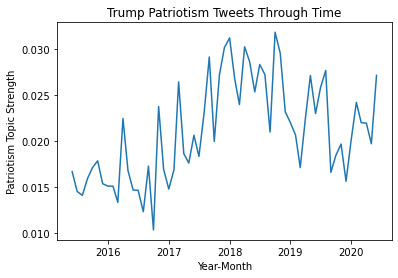

In [108]:
plt.plot(comp_df['DATE'], comp_df['Patriotism_1'])
plt.title('Trump Patriotism Tweets Through Time')
plt.xlabel('Year-Month')
plt.ylabel('Patriotism Topic Strength')
plt.show()

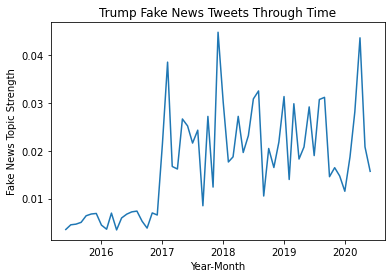

In [112]:
plt.plot(comp_df['DATE'], comp_df['Fake_News'])
plt.title('Trump Fake News Tweets Through Time')
plt.xlabel('Year-Month')
plt.ylabel('Fake News Topic Strength')
plt.show()

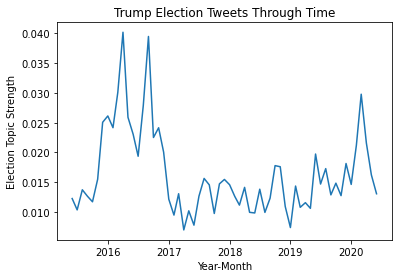

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

In [114]:
plt.plot(comp_df['DATE'], comp_df['Election'])
plt.title('Trump Election Tweets Through Time')
plt.xlabel('Year-Month')
plt.ylabel('Election Topic Strength')
plt.show()

plt.save()

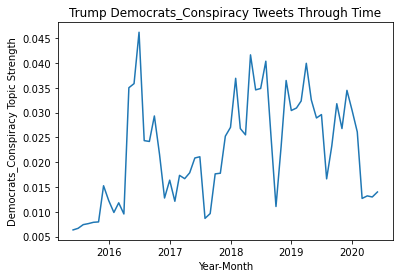

In [113]:
plt.plot(comp_df['DATE'], comp_df['Democrats_Conspiracy'])
plt.title('Trump Democrats_Conspiracy Tweets Through Time')
plt.xlabel('Year-Month')
plt.ylabel('Democrats_Conspiracy Topic Strength')
plt.show()

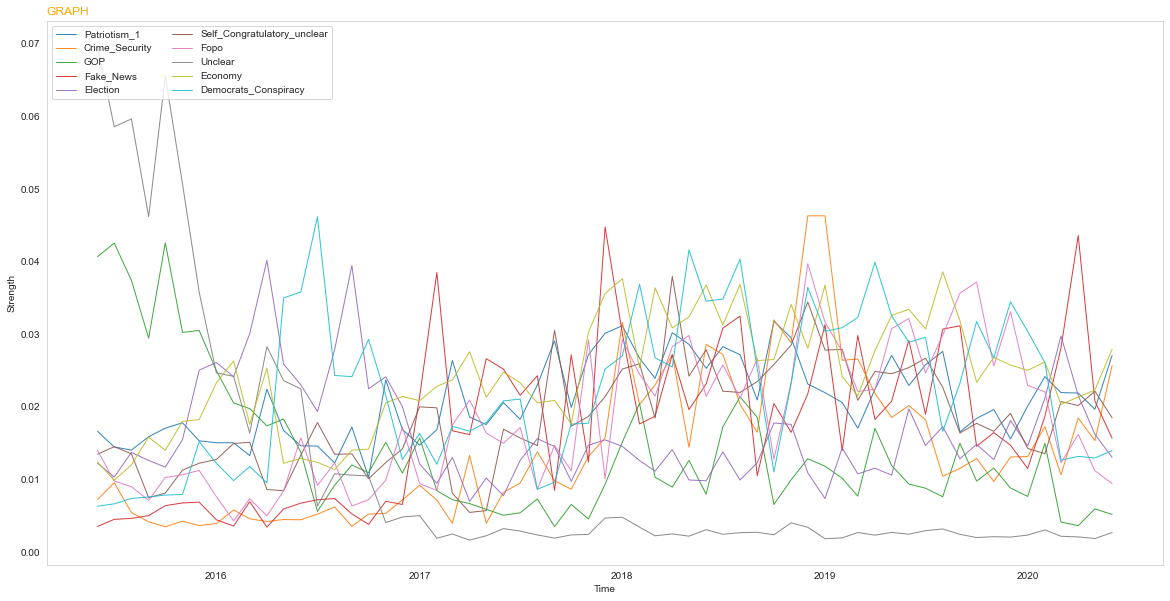

In [135]:
# multiple line plot
num=0
plt.figure(figsize=(20,10)) 
for column in comp_df.drop(['DATE', 'month', 'year'], axis=1):
    num+=1
    plt.plot(comp_df['DATE'], comp_df[column], marker='', linewidth=1, alpha=0.9, label=column)

    # Add legend
    plt.legend(loc=2, ncol=2)

    # Add titles
    plt.title("GRAPH", loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Time")
    plt.ylabel("Strength")

sns.set_style("whitegrid", {'axes.grid' : False})
plt.savefig('trump_topics_bad.jpg')


In [137]:
#for plotting in tableau
comp_df.to_csv(r'/Users/user/desktop/Metis/projects/metis-project-4/monthly_topics.csv', index = False, header=True)